# Classification Analysis Project

* Student name: Linh Mai
* Student pace: self paced
* Scheduled project review date/time: July 13th, 2020 
* Instructor name: Jeff Herman
* Blog post URL: https://linhmai19.github.io/ 


# Column Description 

Below is the description for each of the columns in the cleaned dataset

* state: the state the user lives in
* account length: the number of days the user has this account
* international plan: true if the user has the international plan, otherwise false
* voice mail plan: true if the user has the voice mail plan, otherwise false
* number vmail messages: the number of voice mail messages the user has sent
* total day minutes: total number of minutes the user has been in calls during the day
* total day calls: total number of calls the user has done during the day
* total day charge: total amount of money the user was charged by the Telecom company for calls during the day
* total eve minutes: total number of minutes the user has been in calls during the evening
* total eve calls: total number of calls the user has done during the evening
* total eve charge: total amount of money the user was charged by the Telecom company for calls during the evening
* total night minutes: total number of minutes the user has been in calls during the night
* total night calls: total number of calls the user has done during the night
* total night charge: total amount of money the user was charged by the Telecom company for calls during the night
* total intl minutes: total number of minutes the user has been in international calls
* total intl calls: total number of international calls the user has done
* total intl charge: total amount of money the user was charged by the Telecom company for international calls
* customer service calls: number of customer service calls the user has done
* churn: true if the user terminated the contract, otherwise false
* total charge: total amount of money the user was charged by the Telecom company overall

# Import libraries

In [1]:
import pandas as pd
import numpy as np 
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Import the cleaned dataset and review it

In [2]:
df = pd.read_csv('cleaned_customer_churn.csv')
df = df.drop('Unnamed: 0', 1)
df.head()

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn,total charge
0,KS,128,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False,75.56
1,OH,107,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False,59.24
2,NJ,137,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False,62.29
3,OH,84,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False,66.80
4,OK,75,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False,52.09


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3184 entries, 0 to 3183
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3184 non-null   object 
 1   account length          3184 non-null   int64  
 2   international plan      3184 non-null   object 
 3   voice mail plan         3184 non-null   object 
 4   number vmail messages   3184 non-null   int64  
 5   total day minutes       3184 non-null   float64
 6   total day calls         3184 non-null   int64  
 7   total day charge        3184 non-null   float64
 8   total eve minutes       3184 non-null   float64
 9   total eve calls         3184 non-null   int64  
 10  total eve charge        3184 non-null   float64
 11  total night minutes     3184 non-null   float64
 12  total night calls       3184 non-null   int64  
 13  total night charge      3184 non-null   float64
 14  total intl minutes      3184 non-null   

## Visualize the distribution of the target variable

False    2732
True      452
Name: churn, dtype: int64


(array([0, 1]), <a list of 2 Text xticklabel objects>)

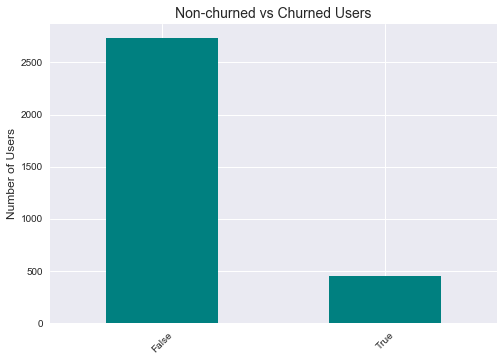

In [4]:
print(df.churn.value_counts())
df['churn'].value_counts().plot(kind='bar', color='teal')
plt.title('Non-churned vs Churned Users', fontsize=14)
plt.ylabel('Number of Users', fontsize=12)
plt.xticks(rotation=45)

##### The amount of non-churned customers are much more than the number of churned customers which created the imbalance in the target varivable. Therefore, in order to biased towards the majority in predictive models later, I need to take into consideration about the use of oversampling when building the models. 

# Visualize the categorical features

In [5]:
# Categorical features
cat_feats = ['state', 'international plan', 'voice mail plan']

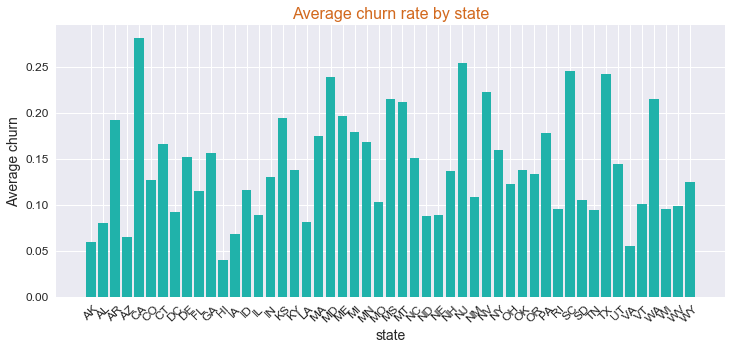

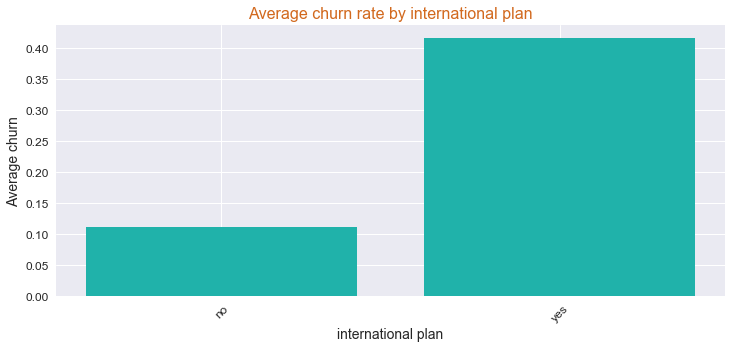

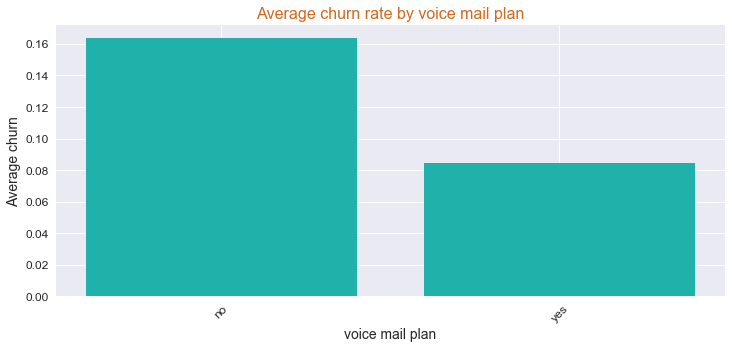

In [6]:
def visualize_influence(feature_list):
    for feature in feature_list:
        df_plot = df.groupby([feature])['churn'].mean().reset_index()
        x = df_plot[feature]
        y = df_plot['churn']
        plt.figure(figsize=(12, 5))
        plt.bar(x, y, color='lightseagreen')
        plt.xlabel(feature, fontsize=14)
        plt.ylabel('Average churn', fontsize=14)
        plt.title(f'Average churn rate by {feature}', fontsize=16, color='chocolate')
        plt.xticks(fontsize=12, rotation=45)
        plt.yticks(fontsize=12)
        plt.show();
        
visualize_influence(cat_feats)

#### General comments on the visualization 
* The states with high amount of churned customers are CA, MD, NU, SC, and TX
* The states with low amount of churned customers are AK, AZ, HI, and VA
* Customers with the international plan have higher proportion of churn than the customers without
* Nothing special to comment more on the plot for churn rate by voice mail plan

# Visualize the continuous features

In [7]:
# Continuous features
con_feats = ['account length', 'number vmail messages', 'total day minutes', 'total day calls', 
             'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge',
             'total night minutes', 'total night calls', 'total night charge', 'total intl minutes',
             'total intl calls', 'total intl charge', 'customer service calls', 'total charge']

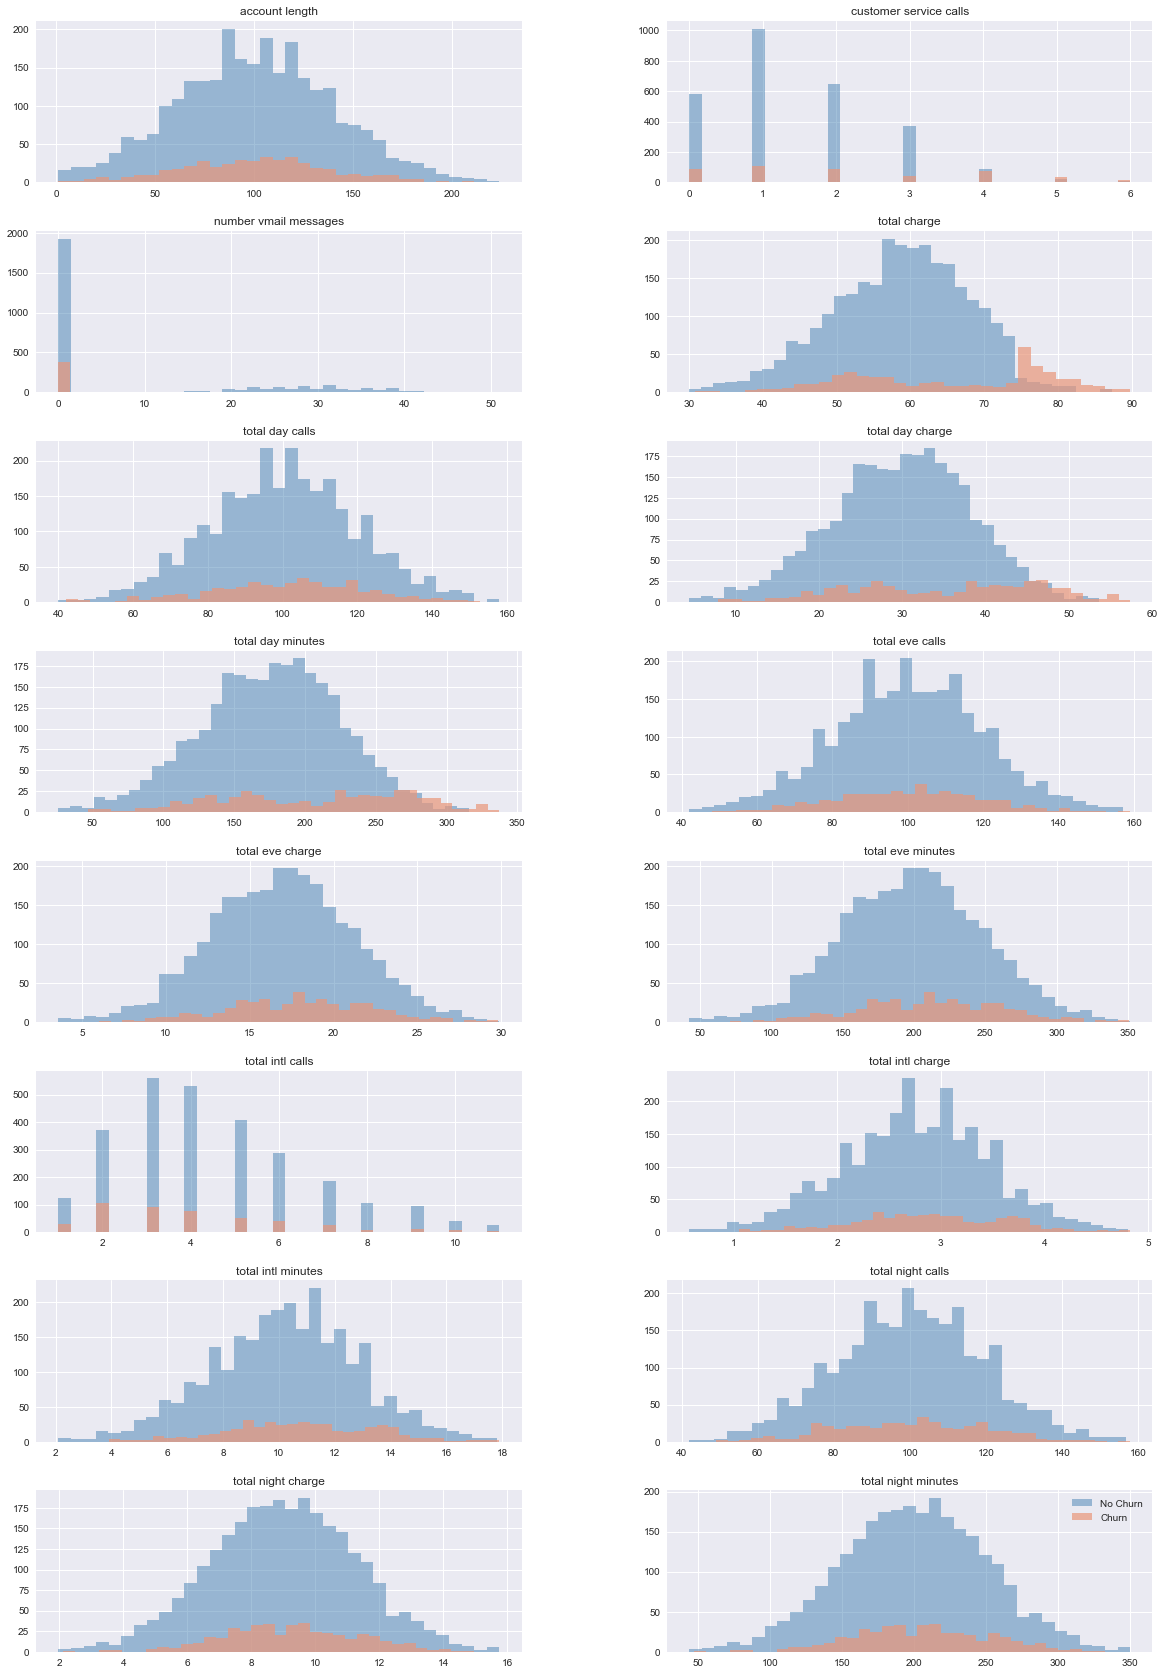

In [8]:
fig, ax = plt.subplots(8, 2, figsize=(20, 30))
df[df.churn == False][con_feats].hist(bins=35, color="steelblue", alpha=0.5, ax=ax)
df[df.churn == True][con_feats].hist(bins=35, color="darksalmon", alpha=0.7, ax=ax)
plt.legend(['No Churn', 'Churn'])

#### General comments on the visualization 
* 'customer service calls' is positively skewed. 
* In the'total intl calls' histogram, both churned and non-churned users are having a similar number of international calls
* In the histograms for 'total day minutes', 'total_day_charge', and 'total charge', the customer with higher values in these features are more likely to churn 
* In the 'total intl minutes' histogram, churned customers tend to have longer international calls (longer in minutes) than non-churned customers
* In the 'number vmail messages' histogram, the users who did not churn tends to have more voice mail messages

# Deal with categorical features

In [9]:
# LabelEncoding the categorical features into numeric values
label_encode = LabelEncoder()

df['state'] = label_encode.fit_transform(df['state'])
df['international plan'] = label_encode.fit_transform(df['international plan'])
df['voice mail plan'] = label_encode.fit_transform(df['voice mail plan'])

In [10]:
# Check the data types in columns and some general information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3184 entries, 0 to 3183
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3184 non-null   int32  
 1   account length          3184 non-null   int64  
 2   international plan      3184 non-null   int32  
 3   voice mail plan         3184 non-null   int32  
 4   number vmail messages   3184 non-null   int64  
 5   total day minutes       3184 non-null   float64
 6   total day calls         3184 non-null   int64  
 7   total day charge        3184 non-null   float64
 8   total eve minutes       3184 non-null   float64
 9   total eve calls         3184 non-null   int64  
 10  total eve charge        3184 non-null   float64
 11  total night minutes     3184 non-null   float64
 12  total night calls       3184 non-null   int64  
 13  total night charge      3184 non-null   float64
 14  total intl minutes      3184 non-null   

In [11]:
# Check the dataset again
df.head()

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn,total charge
0,16,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False,75.56
1,35,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False,59.24
2,31,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False,62.29
3,35,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False,66.80
4,36,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False,52.09


# Explore the relationships between variables

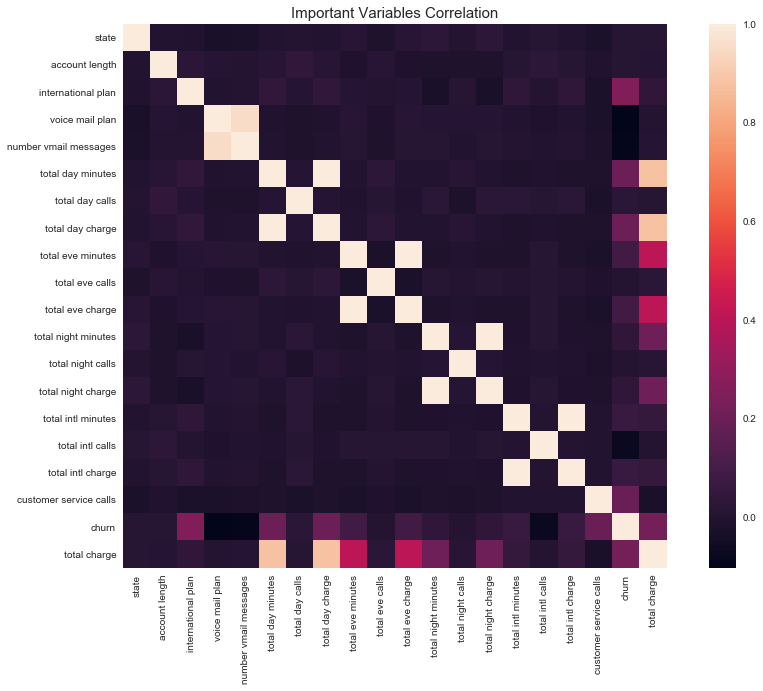

In [12]:
corr = df.corr(method='pearson')
f, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(corr, vmax=1., square=True)
plt.title("Important Variables Correlation", fontsize=15)
plt.show()

#### General comments on the correlation between features and target
* High correlation between 'voice mail plan' and 'number vmail messages' --> makes sense because customers with a voice mail plan send more voice mail messages
* Greatly high correlation between 'total day minutes' and 'total day charge'. I also found the same patterns for other pairs: 'total eve minutes' and 'total eve charge', 'total night minutes' and 'total night charge', and 'total intl minutes' and 'total intl charge' --> the telecom company seems to charge customers by minutes of calls
* There are also a slightly lower correlations between 'total charge' with 'total day minutes', and with 'total day charge'

In [13]:
# Calculate correlation of each feature to price and sort in descending order

corr = df.corr()
corr = corr.stack().reset_index()
corr = corr.rename(columns = {'level_0':'Target', 'level_1':'Features', 0:'Correlation_Values'})
corr = corr.loc[corr['Target'] == 'churn']
corr.sort_values(by = 'Correlation_Values', ascending = False)

,Target,Features,Correlation_Values
378,churn,churn,1.000000
362,churn,international plan,0.258804
379,churn,total charge,0.226858
365,churn,total day minutes,0.199719
367,churn,total day charge,0.199718
377,churn,customer service calls,0.199246
368,churn,total eve minutes,0.089830
370,churn,total eve charge,0.089822
376,churn,total intl charge,0.063996
374,churn,total intl minutes,0.063968


# Standardize features and Train Test Split

In [25]:
# Create features X and target y
y = df['churn']
X = df.drop('churn', axis=1)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data 
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

# Build the Baseline Model

Build a baseline model with Logistic Regression 

In [26]:
# Fit a model
logreg = LogisticRegression(fit_intercept=False, C=1e15, solver='liblinear')
base_model_log = logreg.fit(X_train_scaled, y_train)
# Preview model params
print(base_model_log)

LogisticRegression(C=1000000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [27]:
# Mean cross validation score of the baseline model
mean_logreg_score = np.mean(cross_val_score(logreg, X_train, y_train, cv=3))
print(f'Mean Cross Validation Score: {mean_logreg_score: .2%}')

Mean Cross Validation Score:  86.38%


In [29]:
# Model prediction
logreg_train_pred = logreg.predict(X_train)
logreg_test_pred = logreg.predict(X_test)
test_pred = base_model_log.predict(X_test)

# Classification report for the baseline model
base_model_report = classification_report(y_test, test_pred)
print('Baseline Model Classification Report')
print('------------------------------------')
print(base_model_report)

Baseline Model Classification Report
------------------------------------
              precision    recall  f1-score   support

       False       0.84      1.00      0.91       532
        True       0.00      0.00      0.00       105

    accuracy                           0.84       637
   macro avg       0.42      0.50      0.46       637
weighted avg       0.70      0.84      0.76       637



#### Confusion matrix for the baseline model

In [30]:
cnf_matrix = confusion_matrix(y_test, logreg_test_pred)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[532   0]
 [105   0]]


In [42]:
# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, cmap=cmap)
    
    # Add title and axis labels 
    plt.title('Confusion Matrix') 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label')
    
    # Add appropriate axis scales
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Text formatting
    fmt = '.2f' if normalize else 'd'
    # Add labels to each cell
    thresh = cm.max() / 2.
    # Here we iterate through the confusion matrix and append labels to our visualization 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    
    # Add a legend
    plt.colorbar()
    plt.show() 

Confusion matrix, without normalization


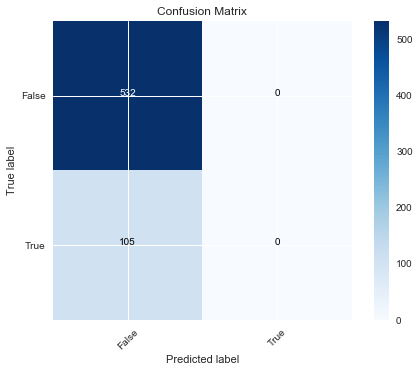

In [43]:
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False)